In [38]:

# Default locations if parameter not passed
benchmark_data_path = "pkl/big-matrix-coaraci-345171.pkl"


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from rich import print as rprint
import seaborn as sns
import os
from scipy.stats import bootstrap

benchmark_data = pickle.load(open(benchmark_data_path, "rb"))

df = pd.DataFrame(benchmark_data["dataframe"])


rprint(df.columns)
rprint(df.head())
rprint(df.tail())

Index(['name', 'biggest_matrix', 'simu_rr', 'node_count', 'full_output',
       'hosts', 'time'],
      dtype='object')

name  biggest_matrix  simu_rr  node_count  full_output  \
0  big-matrix             NaN      NaN          10          NaN   

                                               hosts       time  
0  r2n07,r3n14,r3n15,r3n16,r3n17,r3n18,r3n29,r3n3...  36.344683

name  biggest_matrix  simu_rr  node_count  full_output  \
0  big-matrix             NaN      NaN          10          NaN   

                                               hosts       time  
0  r2n07,r3n14,r3n15,r3n16,r3n17,r3n18,r3n29,r3n3...  36.344683

In [40]:
sns.set_theme()

colors = [
    "#7f7f7f",  # grey
    "#621dac",  # main purple
    "#c5702d",  # orange
    "#000000",  # black,
    "#099892",  # teal
    "#ffd400",  # yellow
    "#7e57c4",  # pink/purple,
]
colors_backup = colors.copy()

In [41]:
def calculate_bootstrap_error(data):
    n_runs = benchmark_data["config"].metadata.runs
    if n_runs < 2:
        return 0
    res = bootstrap(
        (data,), np.mean, confidence_level=0.95, n_resamples=1000, method="basic"
    )
    return res.standard_error

In [42]:
bench_names = df["name"].unique()
run_metadata = benchmark_data["config"].applications

max_node_count = 0

for bench in bench_names:
    bench_metadata = run_metadata[bench]
    n_runs = benchmark_data["config"].metadata.runs
    print(f"Benchmark: {bench} - Runs: {n_runs}")
    # print(bench_metadata)
    df_bench = df[df["name"] == bench]
    for idx, row in df_bench.iterrows():
        print(f"--- Row {idx} ---")
        if "node_count" in row:
            node_count = row["node_count"]
            if node_count > max_node_count:
                max_node_count = node_count
        for col, val in row.items():
            print(f"{col}: {val}")   # printing val directly never truncates
        print()

max_node_count = int(max_node_count)
print(f"Max node count: {max_node_count}")

Benchmark: big-matrix - Runs: 1
--- Row 0 ---
name: big-matrix
biggest_matrix: nan
simu_rr: nan
node_count: 10
full_output: nan
hosts: r2n07,r3n14,r3n15,r3n16,r3n17,r3n18,r3n29,r3n30,r3n31,r3n32
time: 36.3446833351627

Max node count: 10


# Experiment 1
x-axis: SIM_RR
y_axis: distance 

In [43]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def extract_distance(text):
    matches = re.findall(
        r"Distance\s*:\s*([-+]?(?:\d*\.\d+|\d+)(?:[eE][-+]?\d+)?)",
        str(text)
    )
    return float(matches[-1]) if matches else np.nan

In [44]:
df_dist = df[df["name"] == "simulator-matrix-feed"].copy()
df_dist["distance"] = df_dist["full_output"].apply(extract_distance)
df_dist = df_dist[["simu_rr", "distance"]]

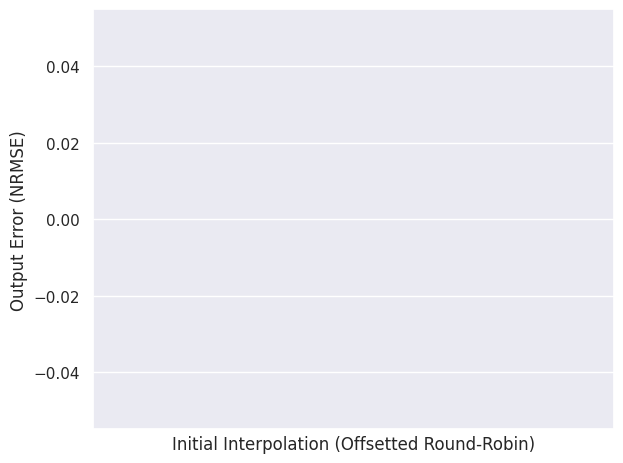

In [45]:
plt.figure()
sns.lineplot(
  data=df_dist,
  x="simu_rr",
  y="distance",
  marker="o",
  errorbar="ci",
)

plt.xlabel("Initial Interpolation (Offsetted Round-Robin)")
plt.ylabel("Output Error (NRMSE)")
#plt.title(f"Simulation Distance per Simulation RR using Matrix trace for {max_node_count-1} workers")
plt.grid(True)
plt.xticks(sorted(df_dist["simu_rr"].unique()))
plt.tight_layout()
plt.savefig("figs/simulator-matrix-feed-distance.pdf")
plt.show()